# Hamiltonian-based mixflows

Here we develop the code for dealing with continuous data
via mixflows using deterministic Hamiltonian dynamics.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [13]:
def flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',direction='fwd',xi=np.pi/16):
    if steps==0: return x,rho,u,np.zeros(x.shape[1])
    
    # define laplace functions
    if momentum=='laplace':
        lm = lambda rho : laplace_lm(rho)
        gradlm = lambda rho : laplace_gradlm(rho)
        Fm = lambda rho : laplace_Fm(rho)
        Qm = lambda p : laplace_Qm(p)
        
    ljs=np.zeros(x.shape[1])
    for t in range(steps):
        if direction=='fwd': x,rho,u,tljs=T_Leps_fwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        if direction=='bwd': x,rho,u,tljs=T_Leps_bwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        ljs+=tljs
    # end for
    return x,rho,u,ljs
    

def T_Leps_fwd(x,rho,u,L,eps,gradlp,logm,gradlm,Fm,Qm,xi=np.pi/16):
    x,rho=Hamiltonian_update(x,rho,L,eps,gradlp,gradlm)
    u=(u+xi)%1
    J=logm(rho)
    rho=Qm((Fm(rho)+prz(x,u))%1)
    return x,rho,u,J-logm(rho)

def T_Leps_bwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi=np.pi/16):
    J=lm(rho)
    rho=Qm((Fm(rho)-prz(x,u))&1)
    u=(u-xi)%1
    x,rho=Hamiltonian_update(x,rho,L,-eps,gradlp,gradlm)
    return x,rho,u,J-logm(rho)

def Hamiltonian_update(x,rho,L,eps,gradlp,gradlm):
    #print('Starting Hamiltonian update')
    #print('Initial x: '+str(x))
    for l in range(L):
        rho+=eps*gradlp(x)/2
        x  -=eps*gradlm(rho)
        rho+=eps*gradlp(x)/2
    # end for
    #print('Final x: '+str(x))
    #print()
    return x,rho
    
    
def prz(x,u): return 0.5*np.sin(2*x+u[np.newaxis,:])+0.5
def laplace_lm(rho): return -np.sum(np.abs(rho),axis=0)-np.log(2)
def laplace_gradlm(rho): return -np.sign(rho)
def laplace_Fm(rho): return -0.5*np.sign(rho)*np.exp(-np.sign(rho)*rho)+0.5+0.5*np.sign(rho)
def laplace_Qm(p): return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5))

In [14]:
# define the target density and score
def lp(x): return -0.5*np.sum(x**2,axis=0)-x.shape[0]*np.log(2*np.pi)/2
def gradlp(x): return -x

M=10
d=1000
x=np.random.randn(M,d)+3
rho=np.random.randn(M,d)
u=np.random.rand(d)

In [15]:
steps=1000
L=50
eps=0.01
tx,trho,tu,tljs=flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',direction='fwd',xi=np.pi/16)

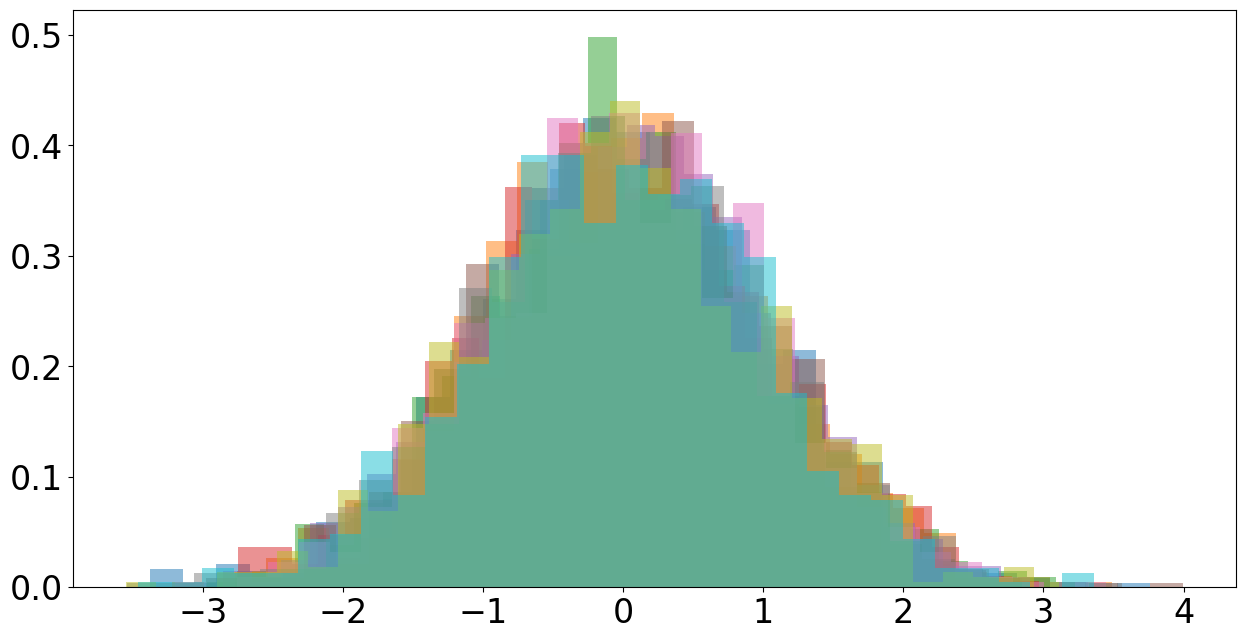

In [16]:
for m in range(M): plt.hist(tx[m,:],bins=30,alpha=0.5,density=True)